In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm

import copy

from plotting import plot_utils, load_fits
from utils import roi_utils
from analyze_features import load_feature_stats

plot_utils.set_all_font_sizes(16)

In [2]:
# Load everything to plot

subjects = np.arange(1,9)
# subjects=np.arange(7,9)
n_subjects = len(subjects)

feature_type_list_long = ['semantic_discrim_raw_val', 'gabor_solo_ridge_12ori_8sf',\
                 'texture_pyramid_ridge_4ori_4sf_pca_HL','sketch_tokens',\
                 'alexnet_best_layer_pca', 'clip_RN50_best_layer_pca']
feature_type_list = ['raw','gabor',\
                 'texture_pyramid','sketch_tokens',\
                 'alexnet', 'clip']
n_models = len(feature_type_list)

which_axes_negate = [1]
axes_to_do_partial = [0,2,3]
discrim_names, signed_names, n_levels = \
    load_feature_stats.load_partial_discrim_names(axes_to_do_partial, which_axes_negate)

n_discrim_types = len(signed_names);

# diff subjects will have diff numbers of voxels
max_voxels = 30000

partial_corrs = np.zeros((n_models, n_discrim_types, n_subjects, max_voxels))
raw_corrs = np.zeros((n_models, n_discrim_types, n_subjects, max_voxels))

n_voxels_each_subj = np.zeros((n_subjects,),dtype=int)

clip_r2 = np.zeros((n_subjects,max_voxels))

min_samp=5;

for si, ss in enumerate(subjects):
    
    for fi, fitting_type in enumerate(feature_type_list_long):

        out= load_fits.load_fit_results(ss, fitting_type,n_from_end=0,verbose=False);
        assert(np.all(out['axes_to_do']==axes_to_do_partial))
        
        if fi==0:
            n_voxels = int(np.sum(out['voxel_mask']))
            n_voxels_each_subj[si] = n_voxels

        c_partial = copy.deepcopy(out['sem_partial_corrs']).T        
        assert(np.all(out['sem_partial_n_samp']>=min_samp))
        c_partial[which_axes_negate,:] *= (-1)
        partial_corrs[fi,:,si,0:n_voxels] = c_partial;
        
        c_raw = out['sem_corr_each_axis'][:,out['axes_to_do']].T
        assert(np.all(out['n_sem_samp_each_axis'][:,out['axes_to_do'],0:2]>=min_samp))
        c_raw[which_axes_negate,:] *= (-1)
        raw_corrs[fi,:,si,0:n_voxels] = c_raw;
        
        if 'clip' in fitting_type:
            # going to use the fit performance of clip model on each voxel, as a threshold for
            # whether to include it. this is very lenient.
            clip_r2[si,0:n_voxels] = out['val_r2'][:,0]

In [3]:
# initialize roi_def objects to get roi indices
roi_def = roi_utils.multi_subject_roi_def(subjects)
roi_names =roi_def.roi_names
n_rois = roi_def.n_rois

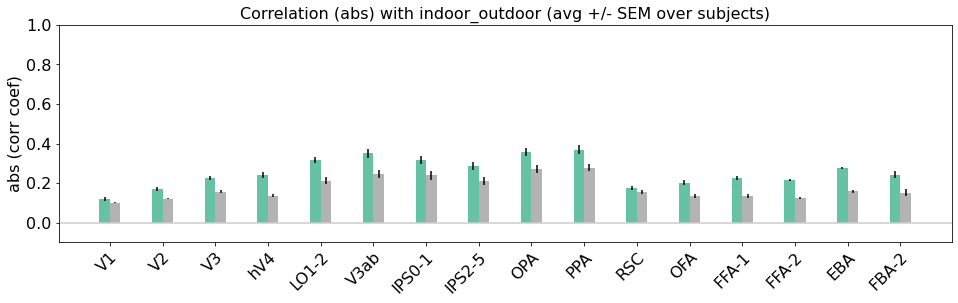

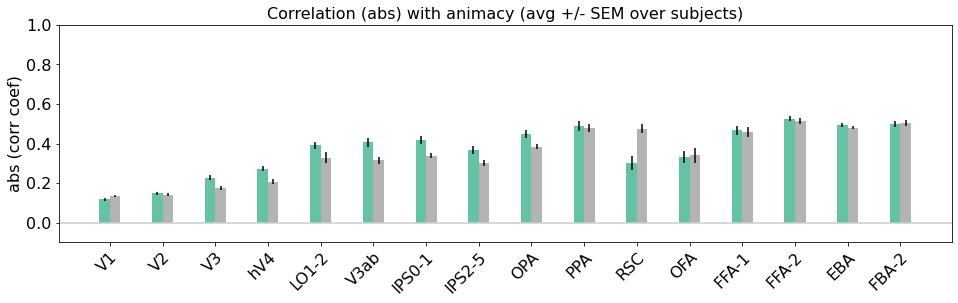

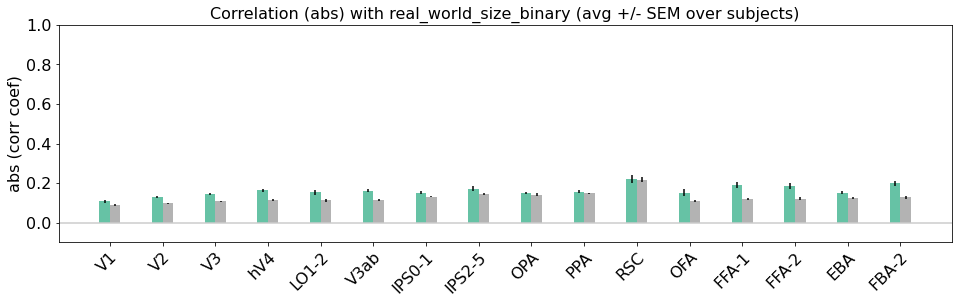

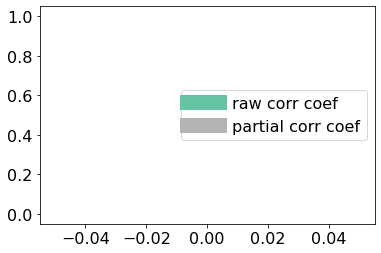

In [12]:
# plot raw and partial corrs side by side, for one model at a time

fi = 5;

r2_thresh = 0.01

colors = cm.Set2(np.linspace(0,1,2))

dd2plot = [0,1,2]

for dd in dd2plot:
    
    discrim_type = discrim_names[dd]
    
    roi_mean_vals = np.zeros((n_rois, 2, n_subjects))
    
    for si in range(n_subjects):
        
        vox2use = clip_r2[si,0:n_voxels_each_subj[si]]>r2_thresh
        vals1 = np.abs(copy.deepcopy(raw_corrs[fi,dd,si,0:n_voxels_each_subj[si]]))
        vals2 = np.abs(copy.deepcopy(partial_corrs[fi,dd,si,0:n_voxels_each_subj[si]]))
        
        vals = np.array([vals1, vals2])
        
        for ri in range(n_rois):

            inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & vox2use

            roi_mean_vals[ri,:,si] = np.mean(vals[:,inds_this_roi], axis=1)
            
    mean_vals = np.mean(roi_mean_vals, axis=2)
    sem_vals = np.std(roi_mean_vals, axis=2)/np.sqrt(n_subjects)
    
    legend_separate = (dd==len(dd2plot)-1)
    title = 'Correlation (abs) with %s (avg +/- SEM over subjects)'%(discrim_type)

    plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=colors, space=0.3, \
                xticklabels=roi_names, ylabel='abs (corr coef)', \
                ylim=[-0.1, 1], title=title, horizontal_line_pos=0,\
                legend_labels=['raw corr coef','partial corr coef'], \
                legend_overlaid=False, legend_separate=legend_separate, \
                fig_size=(16,4))

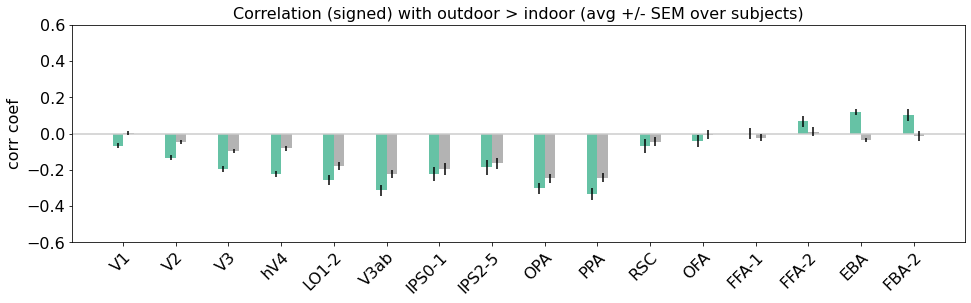

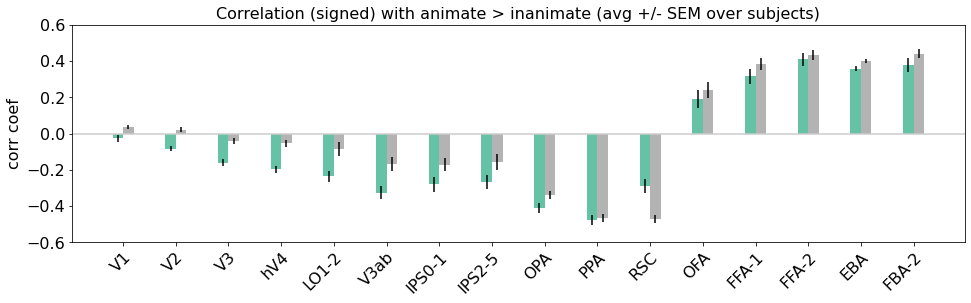

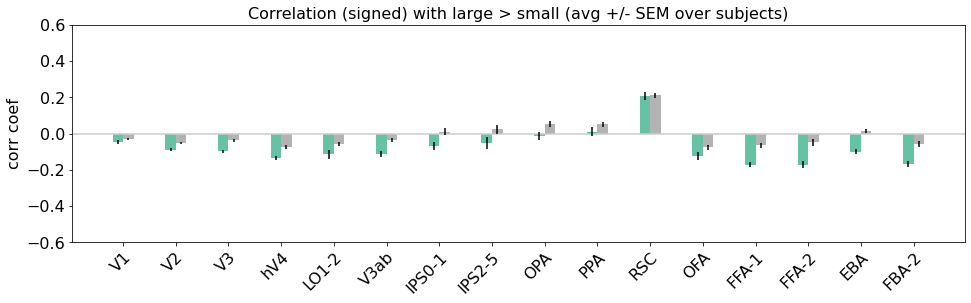

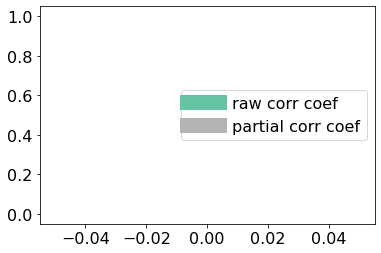

In [15]:
# plot raw and partial corrs side by side, for one model at a time

fi = 5;

r2_thresh = 0.01

colors = cm.Set2(np.linspace(0,1,2))

dd2plot = [0,1,2];

for di,dd in enumerate(dd2plot):
    
    name = signed_names[dd]
    
    roi_mean_vals = np.zeros((n_rois, 2, n_subjects))
    
    for si in range(n_subjects):
        
        vox2use = clip_r2[si,0:n_voxels_each_subj[si]]>r2_thresh
        vals1 = copy.deepcopy(raw_corrs[fi,dd,si,0:n_voxels_each_subj[si]])
        vals2 = copy.deepcopy(partial_corrs[fi,dd,si,0:n_voxels_each_subj[si]])
    
        vals = np.array([vals1, vals2])
       
        for ri in range(n_rois):

            inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & vox2use

            roi_mean_vals[ri,:,si] = np.mean(vals[:,inds_this_roi], axis=1)
            
    mean_vals = np.mean(roi_mean_vals, axis=2)
    sem_vals = np.std(roi_mean_vals, axis=2)/np.sqrt(n_subjects)
    
    legend_separate = (dd==len(dd2plot)-1)
    title = 'Correlation (signed) with %s (avg +/- SEM over subjects)'%(name)

    plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=colors, space=0.3, \
                xticklabels=roi_names, ylabel='corr coef', \
                ylim=[-0.6, 0.6], title=title, horizontal_line_pos=0,\
                legend_labels=['raw corr coef','partial corr coef'], \
                legend_overlaid=False, legend_separate=legend_separate, \
                fig_size=(16,4))

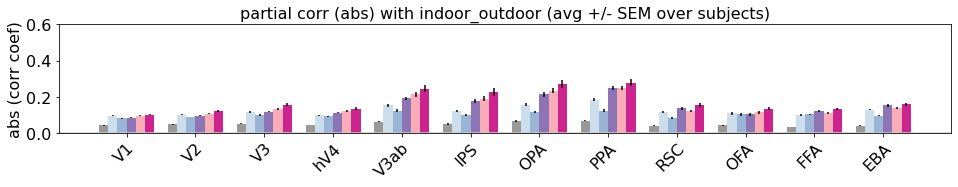

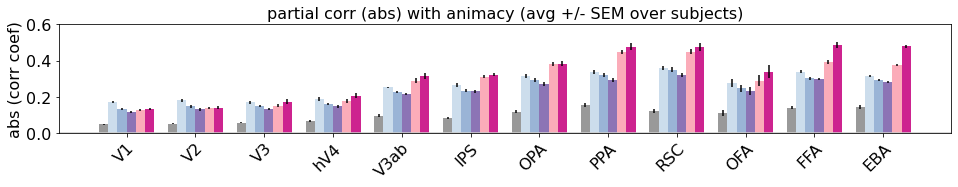

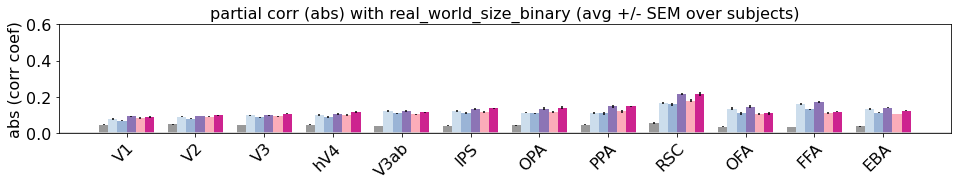

In [9]:
# plot abs partial corr coef for higher-level categories
plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 16)
r2_thresh = 0.01

dnn_colors = cm.RdPu(np.linspace(0,1,4))[1:3,:]
midlevel_colors = cm.BuPu(np.linspace(0,1,6))[1:4,:]
gray_color = np.array([[0.6, 0.6, 0.6, 1]])

model_colors = np.concatenate([gray_color, midlevel_colors, dnn_colors], axis=0)

dd2plot = [0,1,2]

for dd in dd2plot:
    
    discrim_type = discrim_names[dd]
    
    roi_mean_vals = np.zeros((n_rois, n_models, n_subjects))
    
    for si in range(n_subjects):
        
        vox2use = clip_r2[si,0:n_voxels_each_subj[si]]>r2_thresh
        vals = np.abs(copy.deepcopy(partial_corrs[:,dd,si,0:n_voxels_each_subj[si]]))
        
        for ri in range(n_rois):

            inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & vox2use
#             print(np.sum(vals[:,inds_this_roi]==0))
            
            roi_mean_vals[ri,:,si] = np.nanmean(vals[:,inds_this_roi], axis=1)
            
    mean_vals = np.mean(roi_mean_vals, axis=2)
    sem_vals = np.std(roi_mean_vals, axis=2)/np.sqrt(n_subjects)
    
    legend_separate = (dd==len(dd2plot)-1)
    title = 'partial corr (abs) with %s (avg +/- SEM over subjects)'%(discrim_type)

    plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=model_colors, space=0.1, \
                xticklabels=roi_names, ylabel='abs (corr coef)', \
                ylim=[0.0, 0.6], title=title, horizontal_line_pos=0,\
                legend_labels=feature_type_list, \
                legend_overlaid=False, legend_separate=False, \
                fig_size=(16,2))
    
    fn2save = '/user_data/mmhender/imStat/figures/Semantic_%s_selectivity_allmodels.pdf'%discrim_type
    plt.savefig(fn2save)

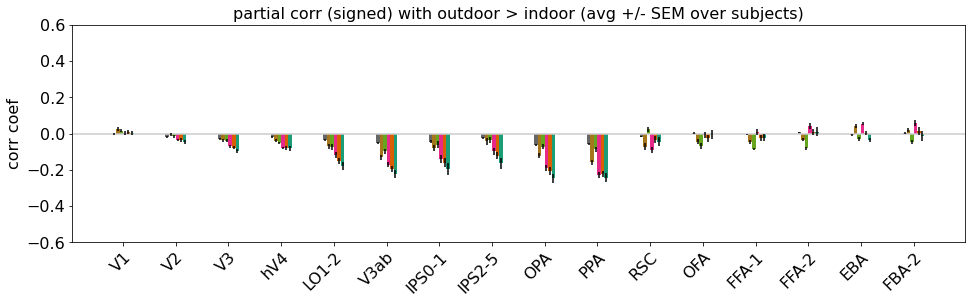

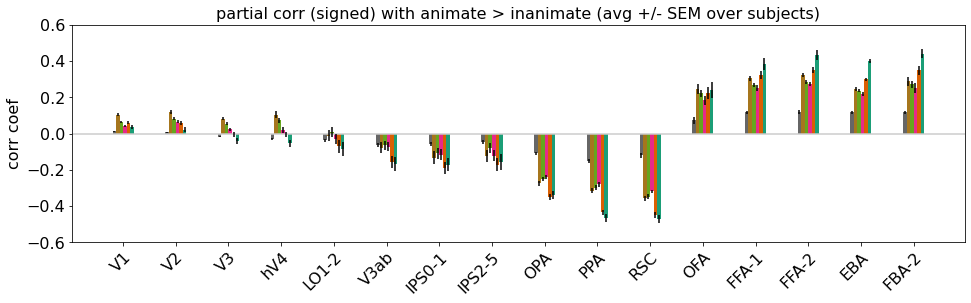

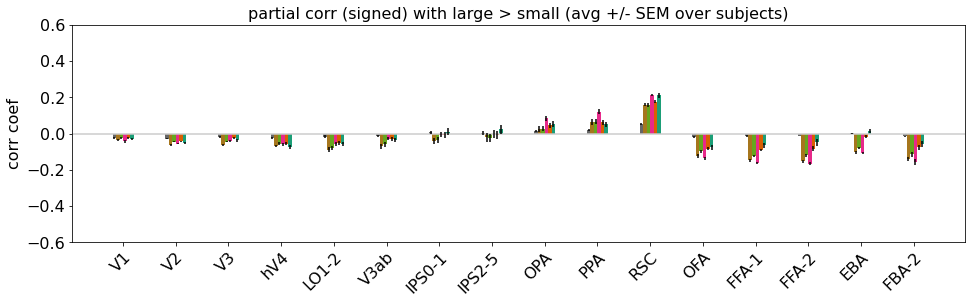

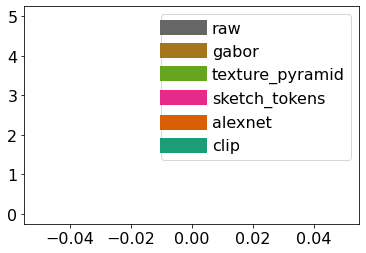

In [17]:
# plot signed partial corr coef for higher-level categories

r2_thresh = 0.01

model_colors = np.flipud(cm.Dark2(np.linspace(0,1,n_models)))

dd2plot = [0,1,2]

for di, dd in enumerate(dd2plot):
    
    name = signed_names[dd]
    
    roi_mean_vals = np.zeros((n_rois, n_models, n_subjects))
    
    for si in range(n_subjects):
        
        vox2use = clip_r2[si,0:n_voxels_each_subj[si]]>r2_thresh
        vals = copy.deepcopy(partial_corrs[:,dd,si,0:n_voxels_each_subj[si]])
        
        for ri in range(n_rois):

            inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & vox2use

            roi_mean_vals[ri,:,si] = np.nanmean(vals[:,inds_this_roi], axis=1)
            
    mean_vals = np.mean(roi_mean_vals, axis=2)
    sem_vals = np.std(roi_mean_vals, axis=2)/np.sqrt(n_subjects)
    
    legend_separate = (dd==len(dd2plot)-1)
    title = 'partial corr (signed) with %s (avg +/- SEM over subjects)'%(name)

    plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=model_colors, space=0.3, \
                xticklabels=roi_names, ylabel='corr coef', \
                ylim=[-0.6, 0.6], title=title, horizontal_line_pos=0,\
                legend_labels=feature_type_list, \
                legend_overlaid=False, legend_separate=legend_separate, \
                fig_size=(16,4))

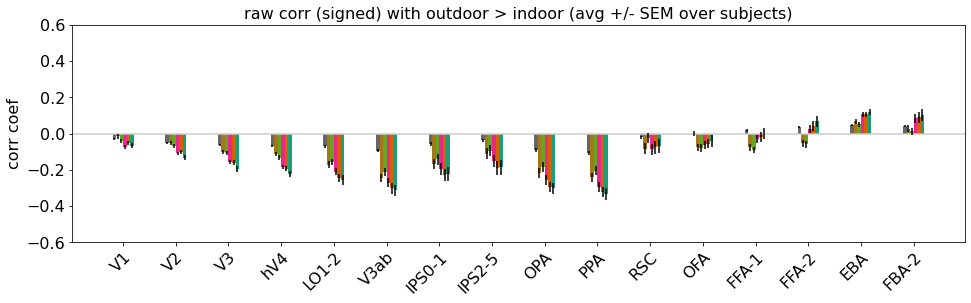

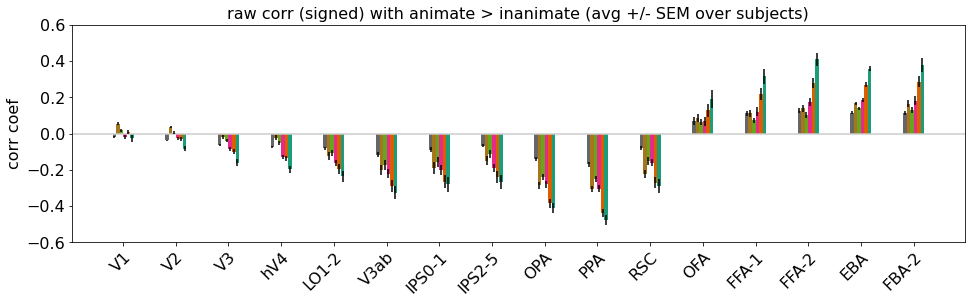

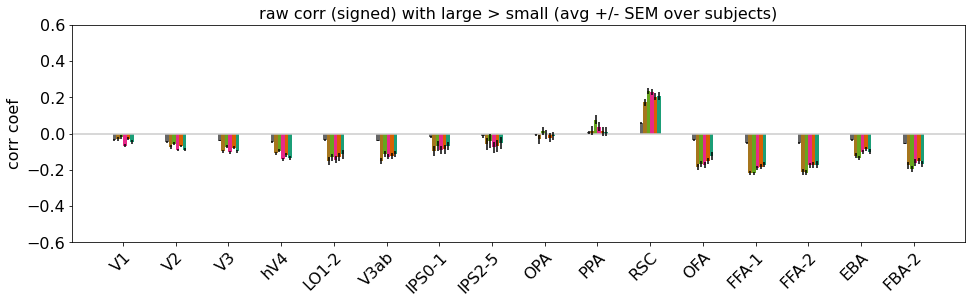

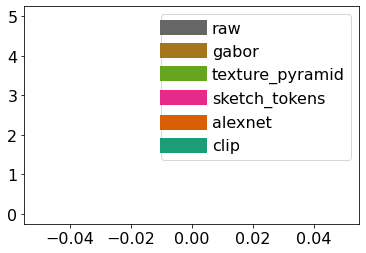

In [18]:
# plot signed partial corr coef for higher-level categories

r2_thresh = 0.01
# r2_thresh = -10

model_colors = np.flipud(cm.Dark2(np.linspace(0,1,n_models)))

dd2plot = [0,1,2]

for di, dd in enumerate(dd2plot):
    
    name = signed_names[dd]
    
    roi_mean_vals = np.zeros((n_rois, n_models, n_subjects))
    
    for si in range(n_subjects):
        
        vox2use = clip_r2[si,0:n_voxels_each_subj[si]]>r2_thresh
        vals = copy.deepcopy(raw_corrs[:,dd,si,0:n_voxels_each_subj[si]])
       
        for ri in range(n_rois):

            inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & vox2use

            roi_mean_vals[ri,:,si] = np.nanmean(vals[:,inds_this_roi], axis=1)
            
    mean_vals = np.mean(roi_mean_vals, axis=2)
    sem_vals = np.std(roi_mean_vals, axis=2)/np.sqrt(n_subjects)
    
    legend_separate = (dd==len(dd2plot)-1)
    title = 'raw corr (signed) with %s (avg +/- SEM over subjects)'%(name)

    plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=model_colors, space=0.3, \
                xticklabels=roi_names, ylabel='corr coef', \
                ylim=[-0.6, 0.6], title=title, horizontal_line_pos=0,\
                legend_labels=feature_type_list, \
                legend_overlaid=False, legend_separate=legend_separate, \
                fig_size=(16,4))